# K Means From Scratch

## The Basic Idea

Given a dataset where each observed example has a set of features, but has
**no** labels. What can we do?

One task we can perform on a data set with no labels is to find groups of data in our dataset
which are similar to one another -- called clusters.

K Means is a clustering algorithm. It stores k centroids that it uses to define clusters. A point
is considered to be in a particular cluster if it is closer to that cluster's centroid that any other
centroid.

## The Algorithm

We are given training sets $\{ x^1, x^2,..., x^m \}$, and want to group the data into a few
cohesive "clusters". Here, we are given feature vectors for each data point $x^i \in\mathbb{R}^n$
as usual. Our goal is to predict k centroids **and** a label $c^i$ for each datapoint.

1. Initialize **cluster centroids** $\mu_1, \mu_2,...,\mu_k\in\mathbb{R}^n$ randomly.
2. Repeat until convergence:

$$
\text{Set } c^i := arg \min_{j} \Vert x^i - \mu_j\Vert ^2 \text{ }\text{  for every i}
$$

$$
\text{Set } \mu_j := \frac{\sum_{i=1}^m \chi_{\{c^i = j\}}x^i}{\sum_{i=1}^m \chi_{\{c^i = j\}}} \text{ }\text{  for every j}
$$


Key ideas:
1. randomly select centroids.
2. calculate distance at each point and assign each point to cluster.
3. calculate average of the assigned point.
4. move centroid to the new position.
5. repeat steps 2-4 until cluster assignment is not changed.

## Implementation

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets._samples_generator import make_blobs

In [2]:
MAX_ITERATIONS = 300

In [3]:
def get_dist(a, b):
    return np.linalg.norm(a - b)

In [4]:
def get_random_centroids(dataset, k):
    temp = []
    n_features = len(dataset[0])
    for i in range(n_features):
        rand_pos = np.random.randint(0.8*np.min(dataset[:, i]), 0.8*np.max(dataset[:, i]),size=k)
        temp.append(rand_pos)

    c_positions = np.array(temp).T

    return c_positions
        

In [5]:
def should_stop(old_centroids, centroids, iterations):
    if iterations > MAX_ITERATIONS:
        return True
    return np.array_equal(old_centroids,centroids)

In [6]:
def kmeans(dataset, centroids, k):
    n = len(dataset)
    clusters = np.zeros(n)
    iterations = 0
    old_centroids = None

    # step 5
    while not should_stop(old_centroids, centroids, iterations):
        for i in range(n):
            # step 2
            distances = [get_dist(dataset[i],c) for c in centroids]
            cluster = np.argmin(distances)
            clusters[i] = cluster
            
        old_centroids = deepcopy(centroids)

        # step 3-4
        for j in range(k):
            points = [dataset[i] for i in range(n) if clusters[i] == j]
            centroids[j] = np.mean(points, axis=0)
        iterations += 1

    return centroids, clusters


### Let's Make Some Data

In [7]:
num_of_centroids = 4
dataset, _ = make_blobs(n_samples=5000, centers=num_of_centroids, n_features=2, random_state=195)

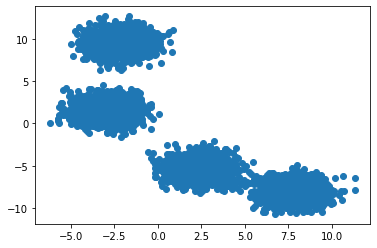

In [8]:
plt.scatter(dataset[:,0], dataset[:, 1])
plt.show()

In [9]:
n_features = 2
c_positions = get_random_centroids(dataset, num_of_centroids) 

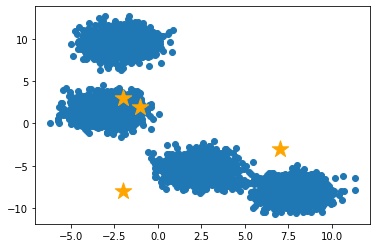

In [10]:
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.scatter(c_positions[:, 0], c_positions[:, 1], marker='*', s=300, c='orange')
plt.show()

## Apply K-Means

In [11]:
new_clusters, clusters_points = kmeans(dataset, c_positions, num_of_centroids)

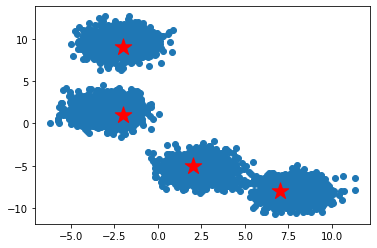

In [12]:
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.scatter(new_clusters[:, 0], new_clusters[:, 1], marker='*', s=300, c='r')
plt.show()

In [13]:
def plot_in_col(x, number_of_clusters, p, new_clusters):
    for i in range(number_of_clusters):
        col_points = np.array([x[n] for n in range(len(x)) if p[n] == i])
        plt.scatter(col_points[:, 0], col_points[:, 1], s=10)
    plt.scatter(new_clusters[:, 0], new_clusters[:, 1], marker='*', s=300, c='w')
    plt.show()

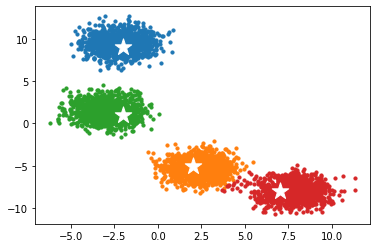

In [14]:
plot_in_col(dataset, num_of_centroids, clusters_points, new_clusters)

## Expectation Maximization

Note that K Mans is really just the Expectation Maximization algorithm applied to a particular
naive bayes model.